<h1>Advanced Validation Assignment</h1>

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#import the dataset
data = pd.read_csv("breast_cancer.csv")
data.head()

,Unnamed: 0,id number,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,0,1000025,5,1,1,1,2,1,3,1,1,0
1,1,1002945,5,4,4,5,7,10,3,2,1,0
2,2,1015425,3,1,1,1,2,2,3,1,1,0
3,3,1016277,6,8,8,1,3,4,3,7,1,0
4,4,1017023,4,1,1,3,2,1,3,1,1,0


In [3]:
#remove wnwanted columns
data = data.drop(['Unnamed: 0', 'id number'], axis=1)

In [4]:
# set malignant to predict the data
y = data.pop("malignant")

In [5]:
#create the split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2, random_state=42)

<h2>Grid Search</h2>
Use Grid Search to optimize model

In [6]:
n_estimators = [i for i in xrange(100, 1001, 100)]
max_features = ['auto', 'sqrt','log2']
min_samples_split = [i for i in xrange(1, 11)]

rfc = RandomForestClassifier(n_jobs=1)
#Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(rfc,
                         dict(n_estimators=n_estimators,
                              max_features=max_features,
                              min_samples_split=min_samples_split
                              ), cv=None, n_jobs=-1)

In [7]:
estimator.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [8]:
estimator.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
best_rfc = estimator.best_estimator_

<h2>Calculate the accuracy</h2>

In [10]:
accuracy = accuracy_score(y_test, best_rfc.predict(X_test))
print "Accuracy: ", accuracy

Accuracy:  0.964285714286


<h2>Precision</h2>

In [11]:
print classification_report(y_test, best_rfc.predict(X_test))

             precision    recall  f1-score   support

          0       0.97      0.98      0.97        95
          1       0.95      0.93      0.94        45

avg / total       0.96      0.96      0.96       140



In [12]:
conf = confusion_matrix(y_test, best_rfc.predict(X_test))
print conf
tp = conf[1][1]
fp = conf[0][1]
fn = conf[1][0]
print "Precision: ", tp  / float(tp + fp)
print "Recall: ", tp  / float(tp + fn)

[[93  2]
 [ 3 42]]
Precision:  0.954545454545
Recall:  0.933333333333


<h2>AUC</h2>

In [13]:
roc = roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:,1])
print "AUC Score: ", roc

AUC Score:  0.99649122807


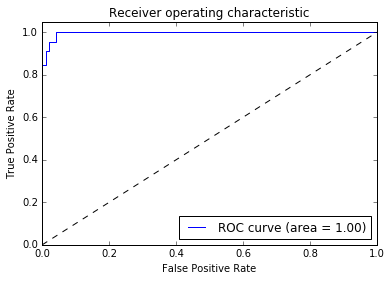

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, best_rfc.predict_proba(X_test)[:,1])
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

<h2>K-Fold Cross Validation</h2>

In [15]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(best_rfc, data, y, cv=10)

In [16]:
scores

array([ 0.92957746,  0.97142857,  0.97142857,  0.91428571,  0.98571429,
        0.98571429,  0.97142857,  0.98571429,  0.98550725,  0.98550725])

In [17]:
mean_score = scores.mean()
std_dev = scores.std()
std_error = scores.std() / math.sqrt(scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Score is %f +/-  %f" % (mean_score, ci)
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

Score is 0.968631 +/-  0.017444
95 percent probability that if this experiment were repeated over and over the average score would be between 0.951187 and 0.986075


<h2>AUC vs K-Fold Score</h2>

single holdout AUC score we obtain from the test is <b>0.99649122807</b> where a K-Fols score we obtained is <b>0.968631 +/-  0.017444</b>. This clerly states  that our model was overfitting. All of K-FOLD CV Scores are worst than the single AUC score. From all the scores it is found that mean of the K-Fold score is nearly 4% lower than the AUC. Also due to the performance problem for the larger dataset we would consider the a train, validate, test split.

<h2>Model Performance Analysis</h2>

<ul>
<li><b>Precision:</b> Test shows that 96% of total population, model will identify correctly and 95% of malignant tumor population will be corectly identified</li>
<li><b>Recall</b>: Recall (0.933333333333). tell us that actual malignancies caught is upto 93% </li>
<li><b>Accuracy:</b>The Accuracy of the model had an average of .96 because the recall and precision both had a .93 chance of predicting non-malignant cancer and a .95 chance of predicting a malignant cancer</li>
<li><b>AUC Score:</b> model's AUC (0.99649122807) is excellent</li>
</ul>

<h2>Summary</h2>

The model performance is good in terms of Accuracy, Precision and recall (~96%) and AUC (~99%). But when compared to K-Fold CV score, these all look overfitting